# Wine Quality Prediction
Guilherme Junqueira Perticarari
___

On this project, I will be analyzing a wine quality dataset, which contains some wine features, such as pH, and its quality, ranked in a 10-scale. Since I am not particularly knowledgeable in wine making practices, I will first explore the dataset to get some real sense of the problem. 

### 1 - Data Acquisition and Cleaning

First of all, I will import all libraries that I will need in order to perform my analysis

In [1009]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.tree import DecisionTreeClassifier
import itertools
from imblearn.over_sampling import SMOTE

%matplotlib inline

Now, I will import the data as it was given to me

In [958]:
data = pd.read_csv('winequality.csv', sep=';')

I will now get a sense of what columns I'll be dealing with and if there are inconsistencies with the data

In [959]:
data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [960]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
type                    6497 non-null object
fixed acidity           6497 non-null float64
volatile acidity        6497 non-null float64
citric acid             6497 non-null float64
residual sugar          6497 non-null float64
chlorides               6497 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null object
quality                 6497 non-null int64
dtypes: float64(10), int64(1), object(2)
memory usage: 659.9+ KB


There are no NaN values on this dataset, but the alcohol column, which should be an int or float from what is shown on 'data.head()', appear to be object. That probably means that some values on it are non-numerical. Let's check.

In [961]:
#Making a copy of the dataframe so that the original dataframe remains untouched
data_temp = data.copy()

def check_type(value):
    try:
        new_value = float(value)
        return True
    except:
        return False
    
data_temp['alcohol_type'] = data_temp.alcohol.apply(check_type)

In [962]:
print('Problematic values:\n\n',data_temp[data_temp.alcohol_type==False]['alcohol'].head())

Problematic values:

 4315    128.933.333.333.333
4319    128.933.333.333.333
4323    114.666.666.666.667
4341    100.333.333.333.333
4353    114.333.333.333.333
Name: alcohol, dtype: object


The values above show exactly what the problem is. Some odd values have been entered on this column instead of floats. Let's check how many of these there are.

True     6457
False      40
Name: alcohol_type, dtype: int64


/Users/guilhermeperticarari/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


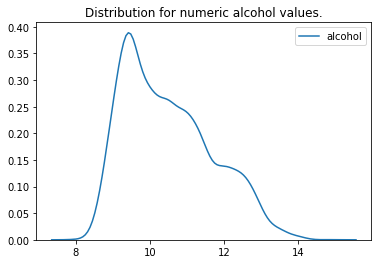

In [963]:
print(data_temp.alcohol_type.value_counts())
sns.kdeplot(data_temp[data_temp.alcohol_type==True].alcohol)
plt.title('Distribution for numeric alcohol values.')
plt.show()

So, only 40 in about 6.5k samples present type error on the alcohol value. The odd values, such as 128.933.333.333.333 doesn't give much of a clue of what it should actually be, because the values for alcohol are all concentrated between 8 and 14 for the numeric samples.
Therefore, it means we can disconsider these samples entirely without losing much information (0.6% of the samples will be lost).

In [964]:
bad_indexes = data_temp[data_temp.alcohol_type==False].index
data_temp.drop(bad_indexes, inplace=True)

Let's now transform all values of alcohol to float.

In [965]:
data_temp['alcohol'] = data_temp['alcohol'].apply(float)

Now that the alcohol problem has been fixed, let's check the statistical summary of the values:

In [966]:
data_temp.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000
mean,7.219475,0.339684,0.318795,5.445973,0.056081,30.495586,115.690801,1.715329,3.218592,0.531169,10.489083,5.817098
std,1.294910,0.164690,0.145506,4.764308,0.035110,17.757007,56.595196,7.659497,0.160845,0.148870,1.192961,0.874125
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992350,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994900,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.997000,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,103.898000,4.010000,2.000000,14.900000,9.000000


The thing that catches my attention is the 100+ density value, when 75% of densities are below 1. Let's check the distribution:

/Users/guilhermeperticarari/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


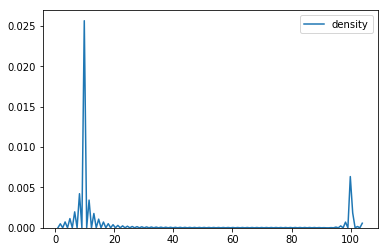

In [967]:
sns.kdeplot(data_temp.density)

This is certainly odd. Let me check how many densities are stated as above 1.

In [968]:
data_temp[data_temp.density>1].shape[0]

147

In [969]:
data_temp.shape[0]

6457

What's most likely to be happening is some unit conversion error, but since there are only some datapoints (110, which is about 2% of the dataset), I will just go ahead and drop them.

In [970]:
data_temp = data_temp[data_temp.density<=1]

/Users/guilhermeperticarari/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


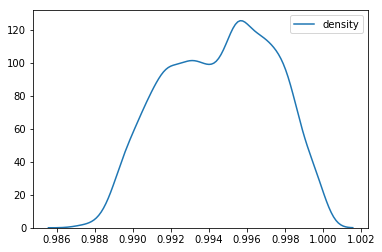

In [971]:
sns.kdeplot(data_temp.density)

Now the density plot looks normal.

Well, since the most notable inconsistencies with data have already been dealt with, I will move on to some Exploratory Analysis.

### 2 - EDA (Exploratory Data Analysis)

Since I am not very familiar with wine making techniques, I will be using the dataset I was given to get a better sense of the business side of the problem. This should help me choose which model(s) to deploy and which features to consider (should I make new ones based on the ones I already have?).

__Red Wine vs White Wine__: I will first check how the distribution of all these metrics change according to the type of wine.

In [972]:
data_temp.type.value_counts()

White    4788
Red      1522
Name: type, dtype: int64

First, it should be noted that the majority of datapoints on this dataset regards white wine (74%)

In [973]:
data_temp = data_temp[data_temp.density<10]

/Users/guilhermeperticarari/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


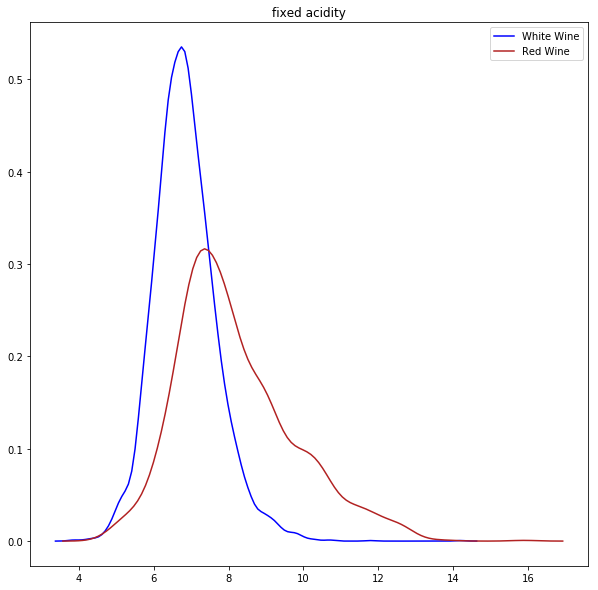

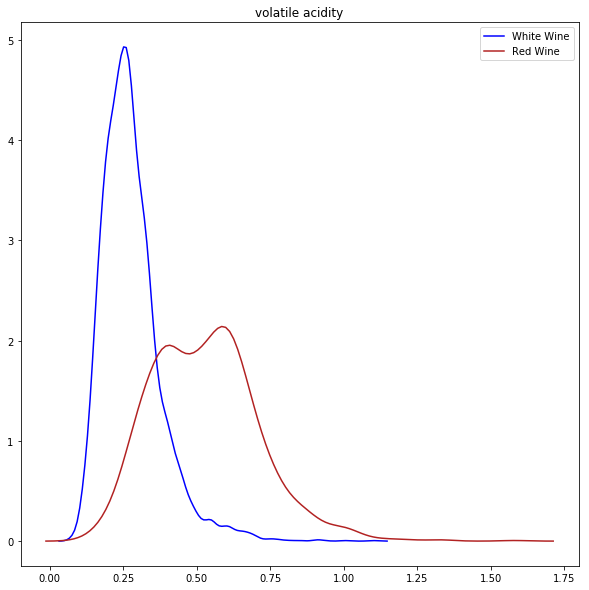

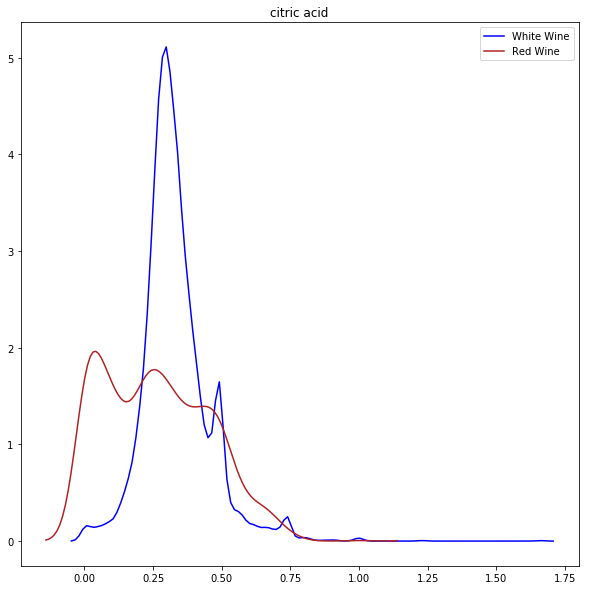

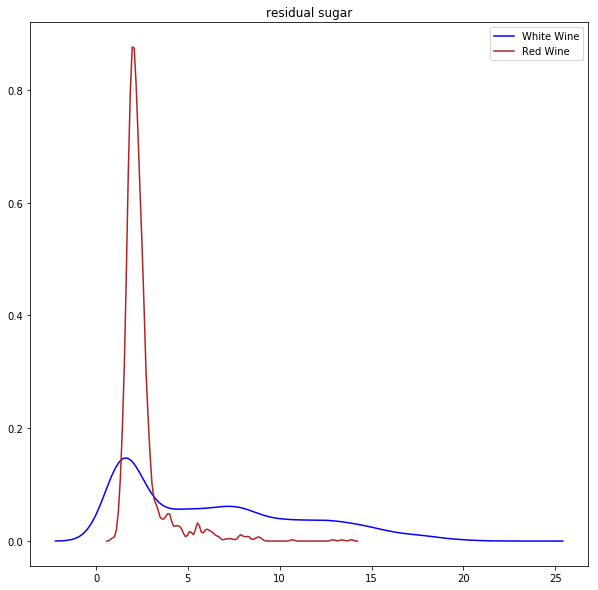

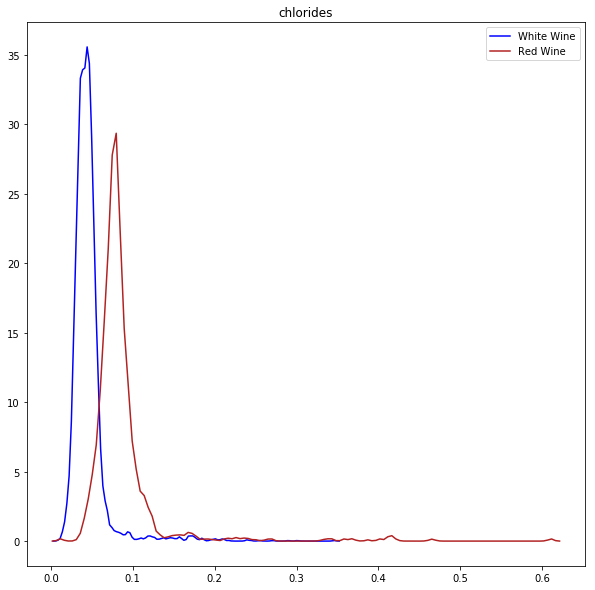

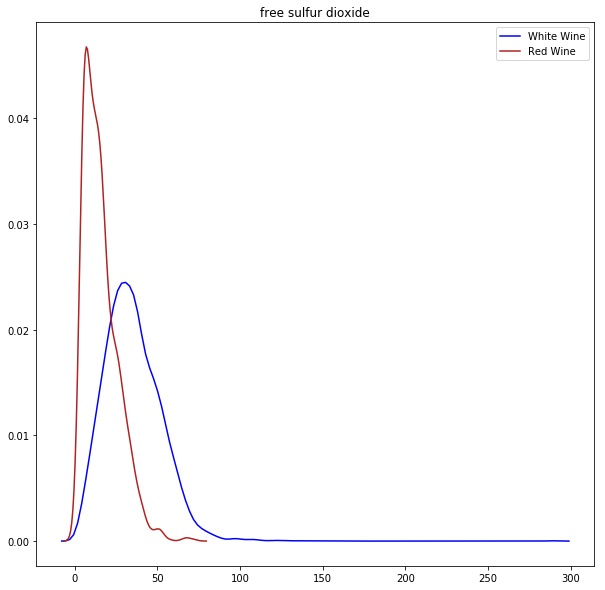

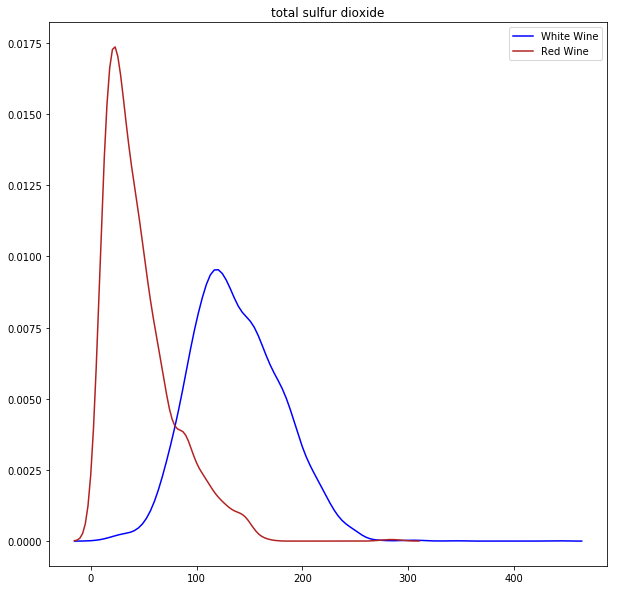

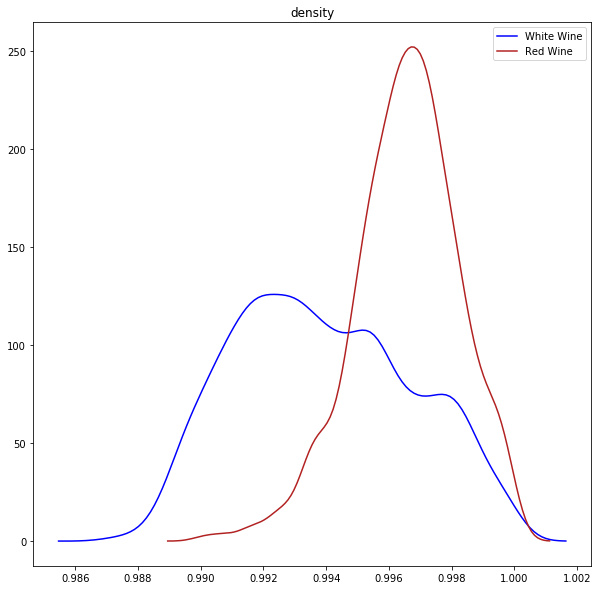

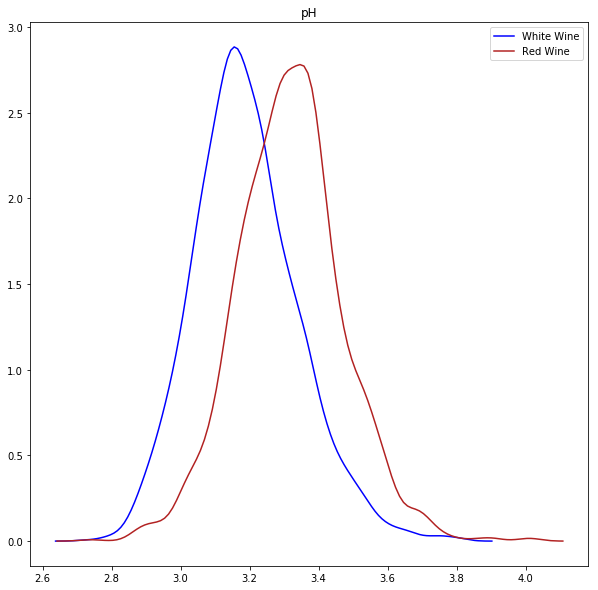

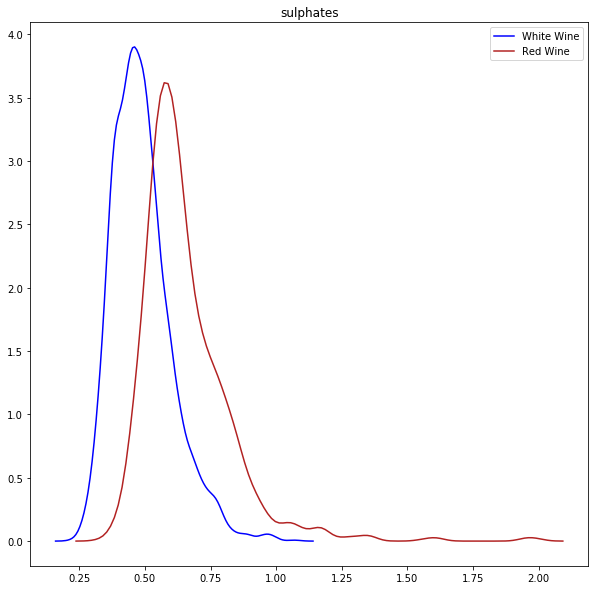

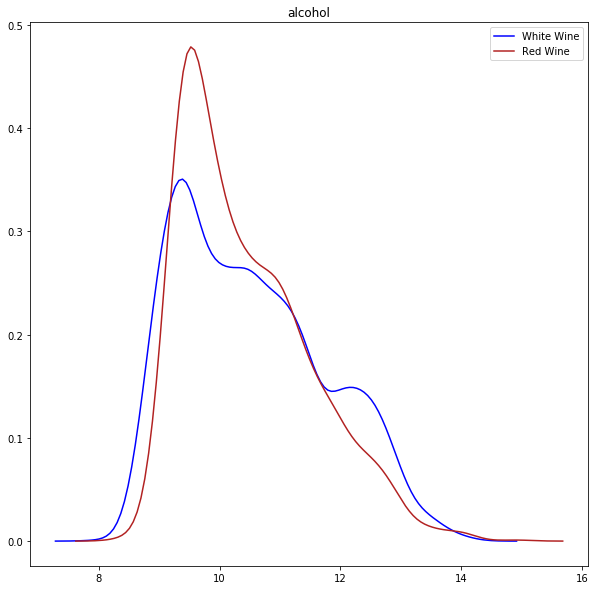

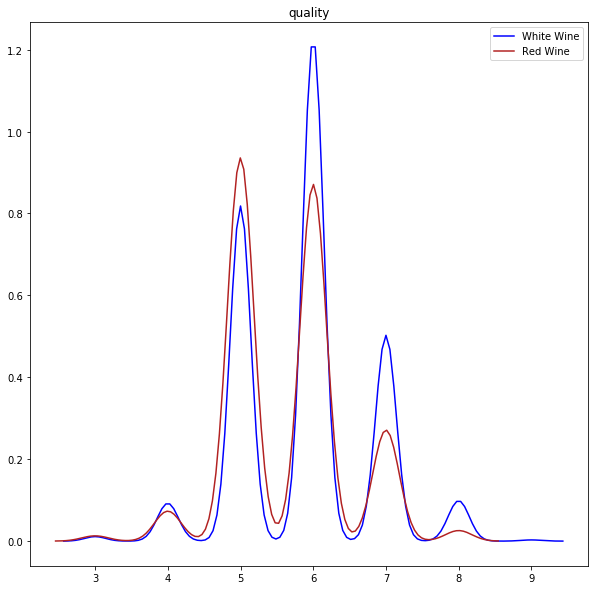

In [974]:
red_wine = data_temp[data_temp.type=='Red']
white_wine = data_temp[data_temp.type=='White']

for metric in data_temp.iloc[:, ~data_temp.columns.isin(['type', 'alcohol_type'])].columns:
    fig, ax = plt.subplots(figsize=(10,10))
    sns.kdeplot(white_wine[metric], ax = ax, label = 'White Wine', color = 'blue')
    sns.kdeplot(red_wine[metric], ax = ax, label = 'Red Wine', color = 'firebrick')
    plt.title(metric)
    plt.axis('auto')
    plt.show()

There are some clear differences between red and white wine, chemically-wise.

1) Red wine presents less total sulfur dioxide than white wine

2) Red wine has a higher pH than white wine

3) Red wine presents more chlorides than white wine

4) Red wine seems to be more dense than white wine


Now, let's check for each metric's influence on quality.

In [975]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6310 entries, 1 to 6496
Data columns (total 14 columns):
type                    6310 non-null object
fixed acidity           6310 non-null float64
volatile acidity        6310 non-null float64
citric acid             6310 non-null float64
residual sugar          6310 non-null float64
chlorides               6310 non-null float64
free sulfur dioxide     6310 non-null float64
total sulfur dioxide    6310 non-null float64
density                 6310 non-null float64
pH                      6310 non-null float64
sulphates               6310 non-null float64
alcohol                 6310 non-null float64
quality                 6310 non-null int64
alcohol_type            6310 non-null bool
dtypes: bool(1), float64(11), int64(1), object(1)
memory usage: 696.3+ KB


/Users/guilhermeperticarari/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


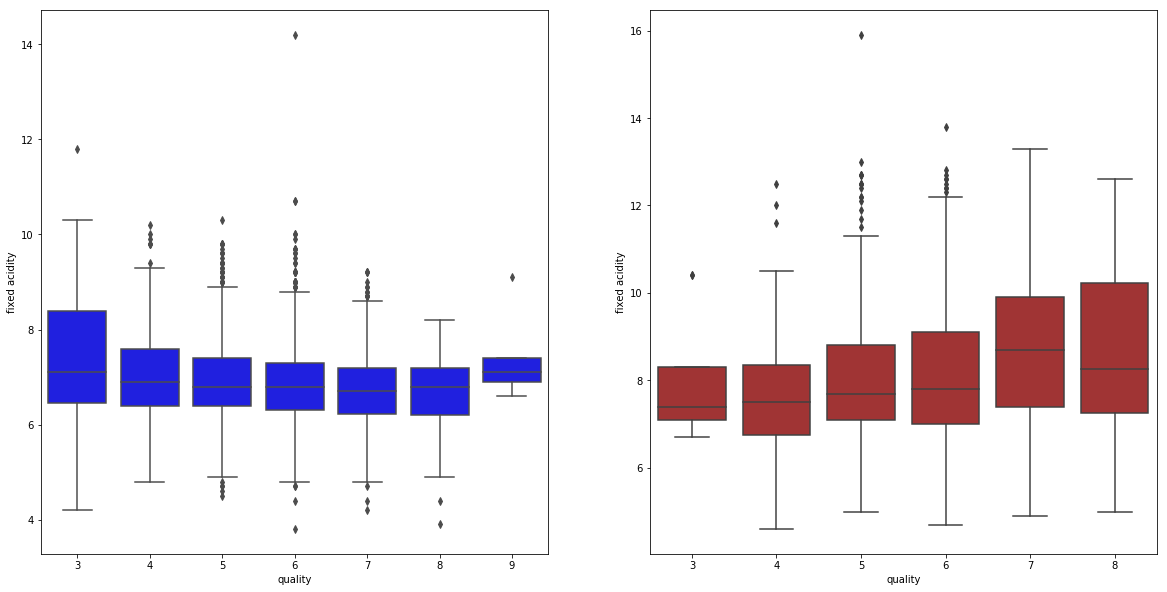

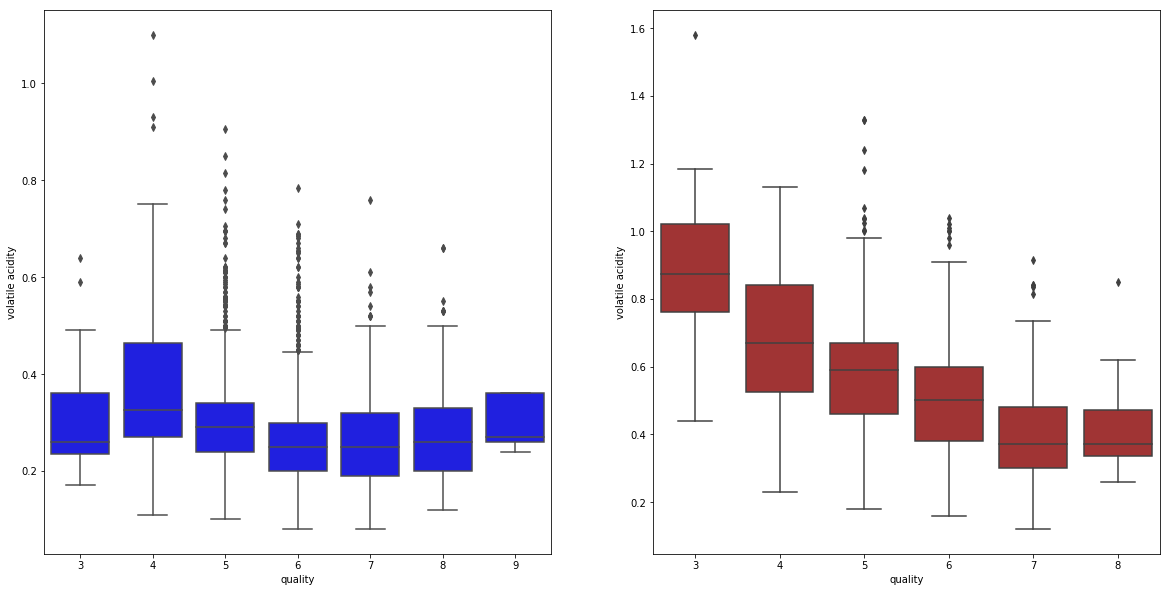

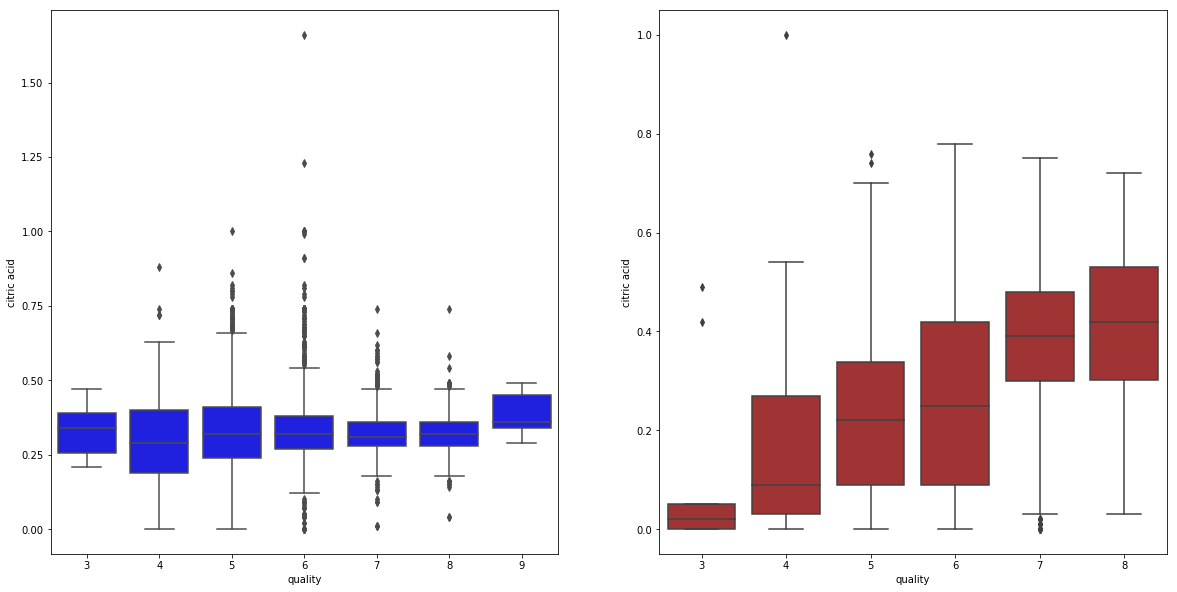

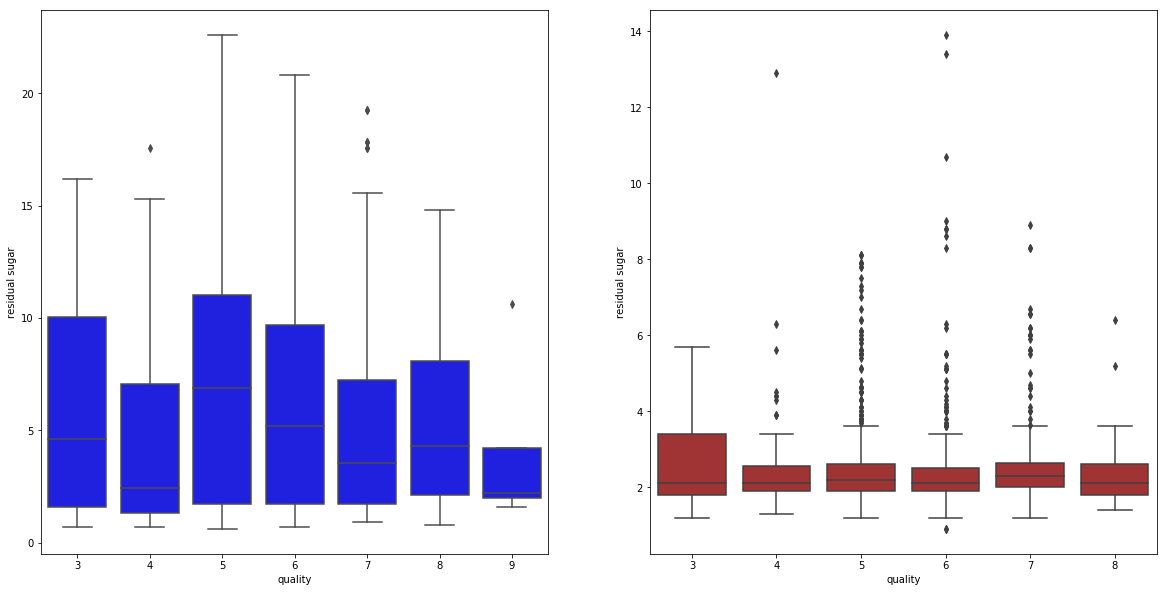

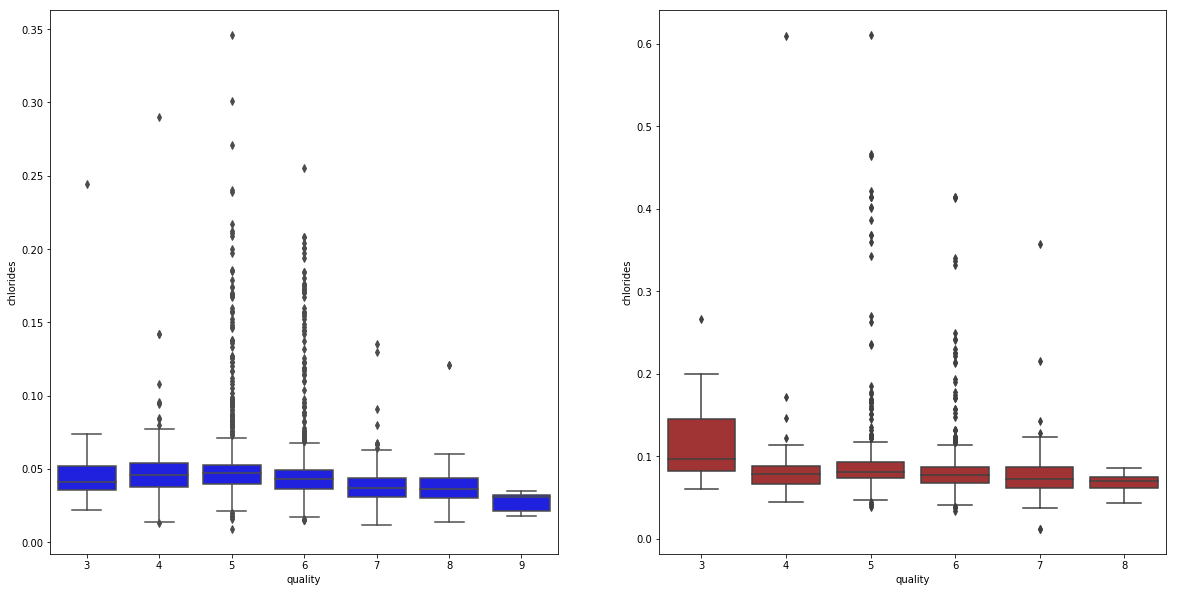

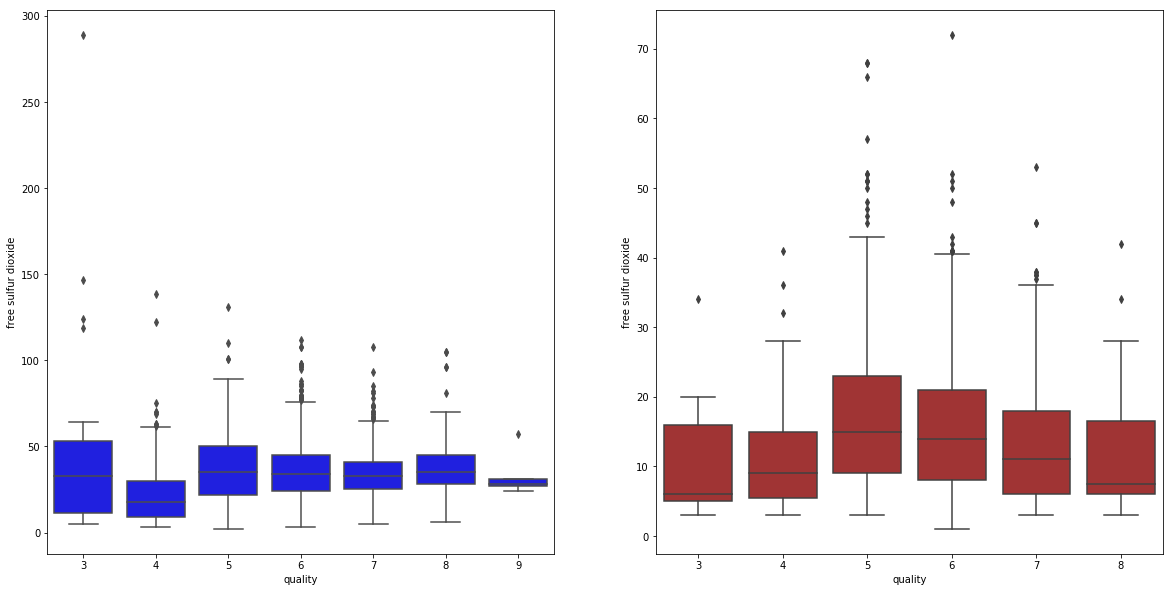

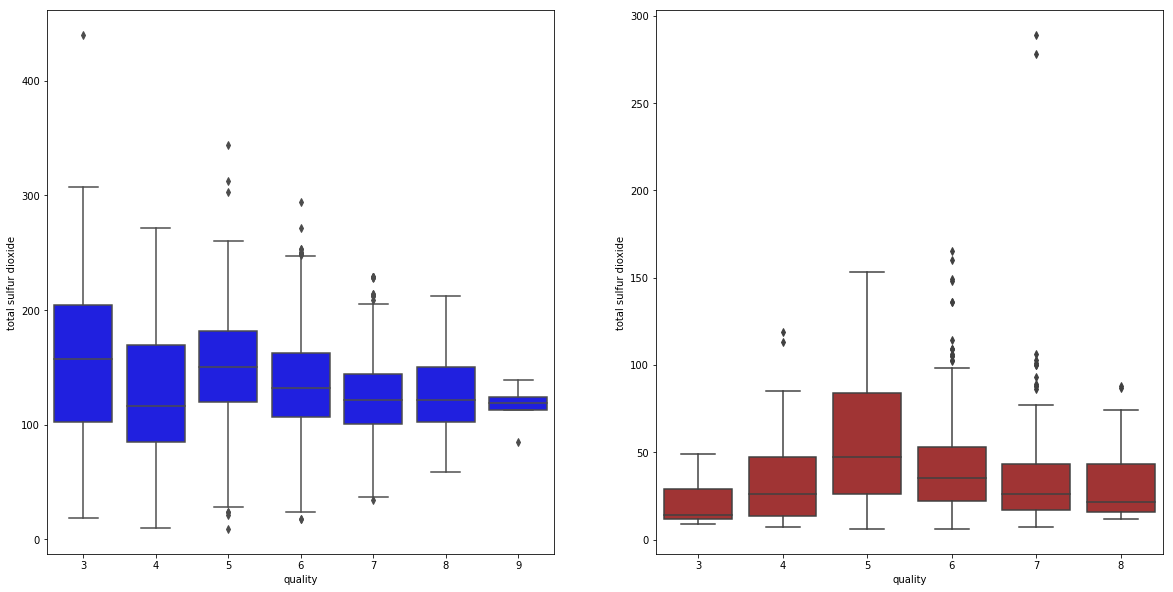

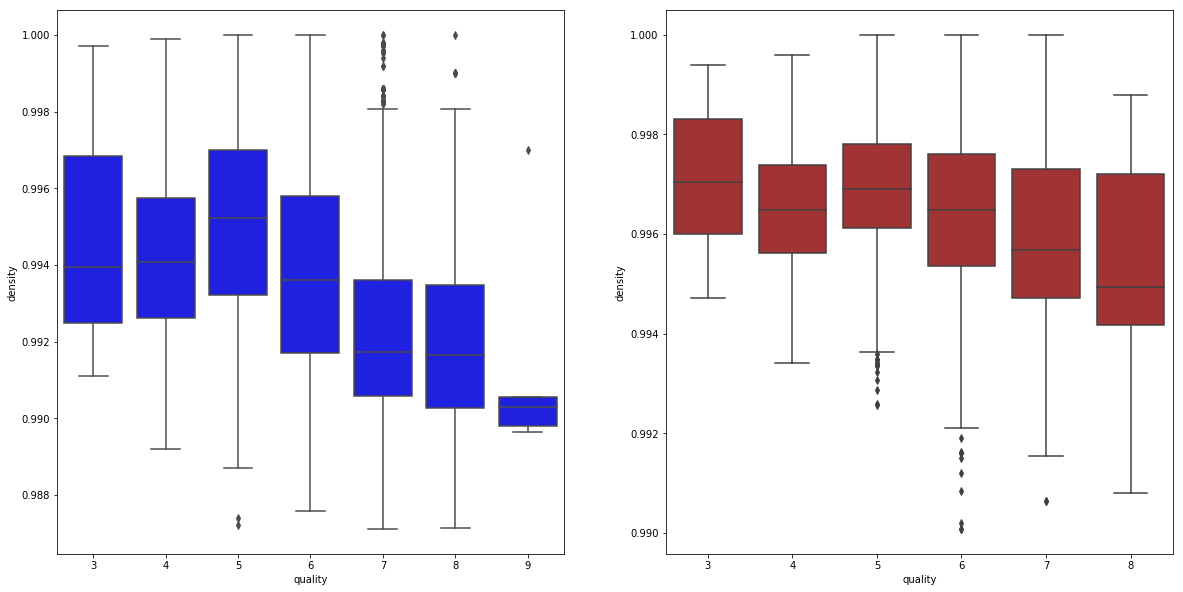

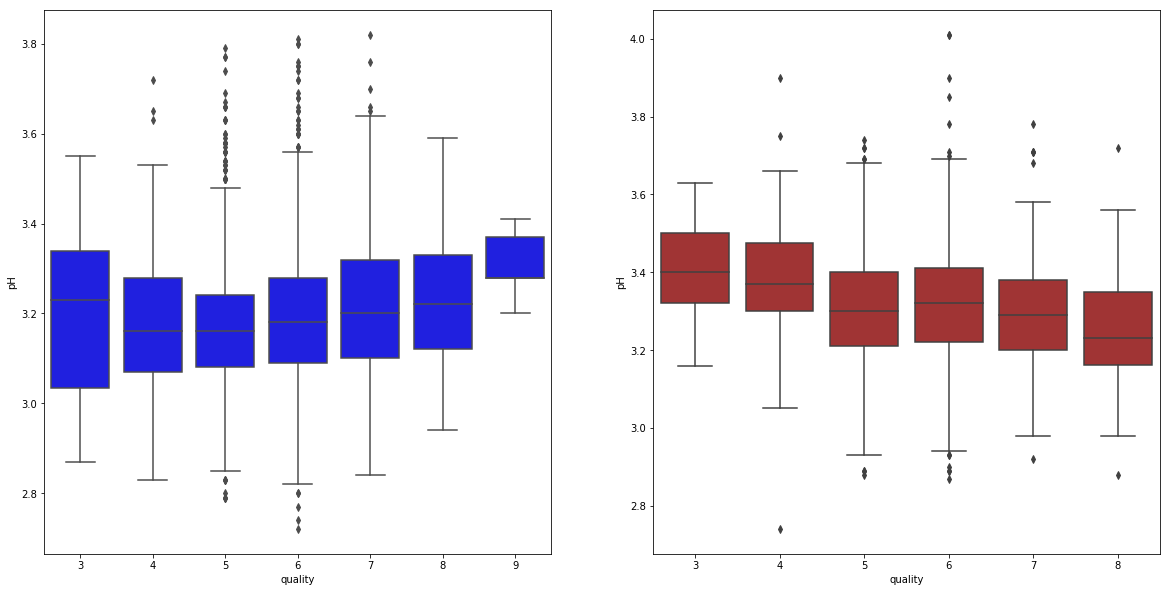

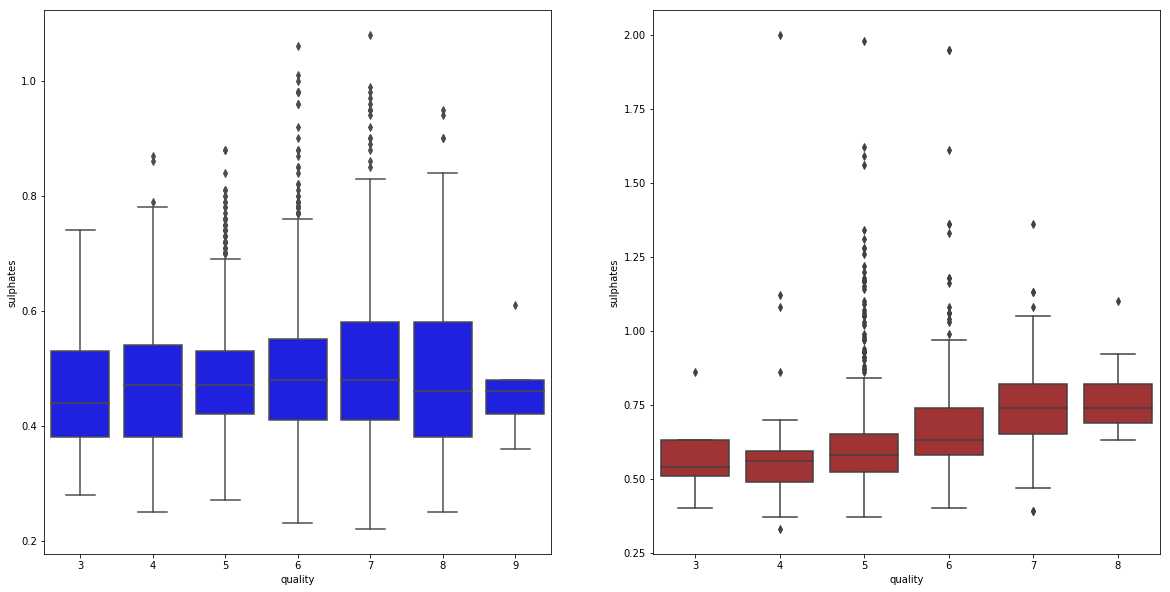

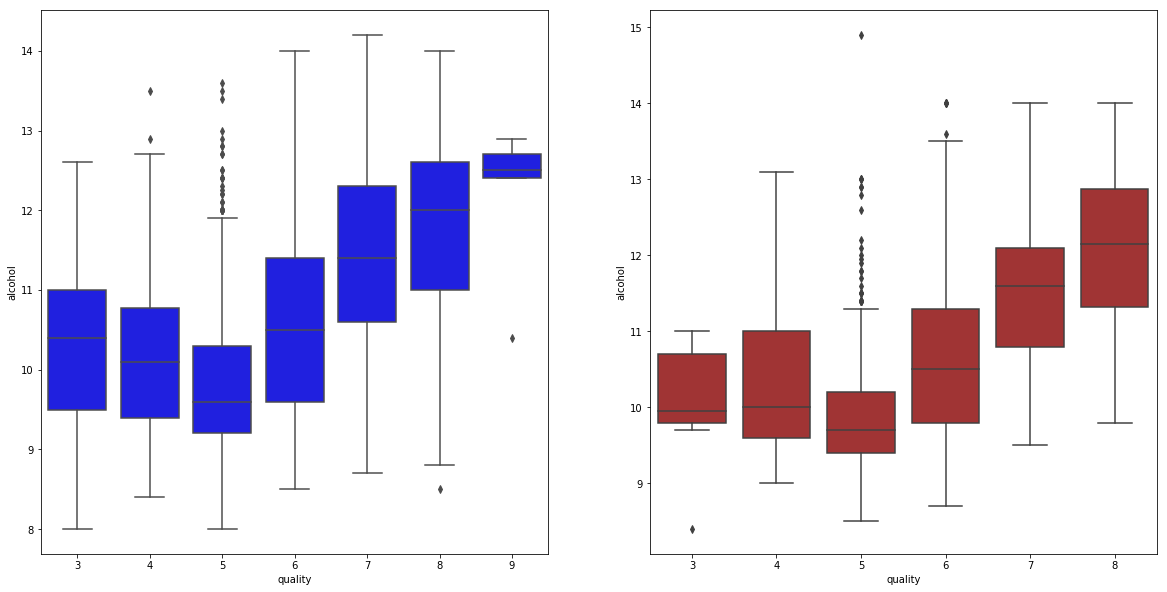

In [976]:
for metric in data_temp.iloc[:, ~data_temp.columns.isin(['type', 'quality', 'alcohol_type'])].columns:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
    sns.boxplot(white_wine['quality'],white_wine[metric], ax = ax1, color = 'blue')
    sns.boxplot(red_wine['quality'],red_wine[metric], ax = ax2, color = 'firebrick')
  

Some of these features seem to affect red and white wine's quality differently. For example, volatile accidity seem to have a bigger effect on red wine's quality than on its white counterpart. But, for the most part, both wine types seem to respond equally to differences on these chemical features.

1) High quality wine seems to be associated with a higher alcohol content

2) Chlorides cause no real difference in red or white wine quality

3) High quality red wine seems to be associated with low volatile accidity, while it doesn't seem to affect white wine's quality

4) Fixed accidity doesn't seem to affect the wine's quality 

5) High quality wine seems to be associated with a lower density

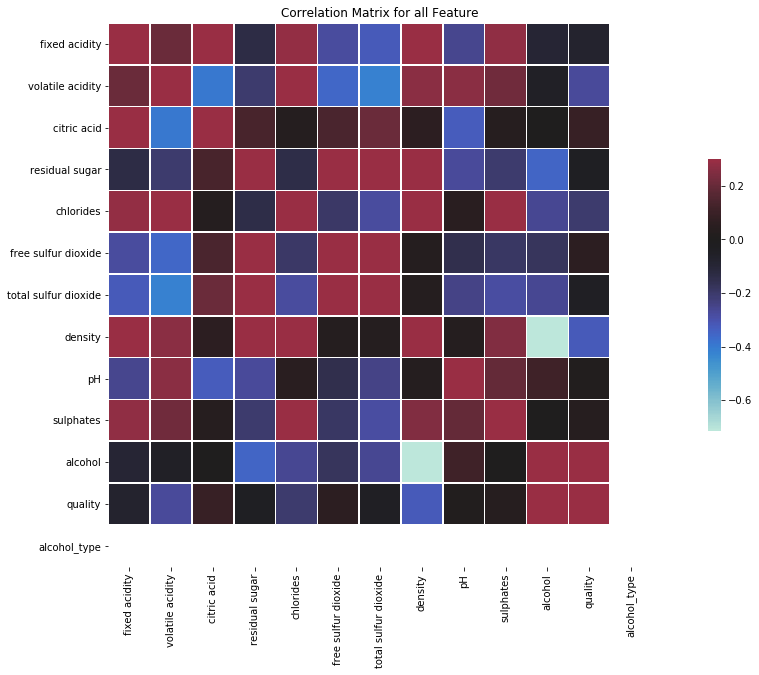

In [978]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(data_temp.corr(), vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix for all Feature')
plt.show()

The correlation matrix above coincides with my previous findings:  alcohol, density andvolatile acidity are the features that correlates the most with quality.

### 3 - Modelling

On this particular problem, I will emphasize on more interpretable kinds of models. That's because I suppose this is the kind of problem that shouldn't be treated as an accurate black-box, but as a logical way of mapping wine chemical features to its quality in order to assist producers what they could change on their ingredients or to help dealers understand how much they can charge for a certain wine and why.

As a criterion function, I will be using the Mean Absolute Deviation, which is appropriate for this scenario, because not only do I wanna make sure that a true-3 is mapped to a predicted-3, but I want to penalize harshly if it gets mapped to a predicted-8. Very different scores cannot be seen as equivalent under any circumstance for this problem.

Strategy: I will evaluate 3 very interpretable models: KNN, Decision Tree and Random Forest. Once one of them is chosen as the best one, given my criterion function, I will tune it using a grid search to find the best hyperparameters.

In [979]:
data_temp = pd.concat([data_temp, pd.get_dummies(data_temp['type'])], axis=1).drop(['type', 'alcohol_type'], axis=1)

In [980]:
data_temp.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Red,White
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1
5,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0,1


In [981]:
x = data_temp.iloc[:, data_temp.columns!='quality']
y = data_temp['quality']

In [982]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)

__KNearestNeighbors__ 

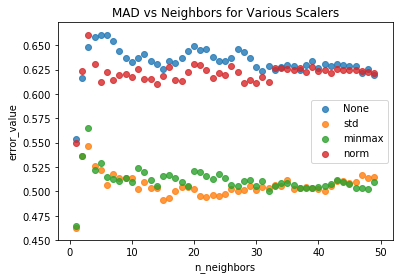

In [987]:
test_error  = {'scaler_type':[],
               'n_neighbors':[],
               'error_value':[]}

min_neighbors = 1
max_neighbors = 50
step_neighbors = 1

for n_neighbors in np.arange(min_neighbors,max_neighbors, step_neighbors):
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(x_train, y_train)
        y_pred = knn.predict(x_test)
        test_error['scaler_type'].append('None')
        test_error['n_neighbors'].append(n_neighbors)
        test_error['error_value'].append(mean_absolute_error(y_true=y_test, y_pred=y_pred))
        
for key, scaler in {'std':StandardScaler(), 
                    'minmax': MinMaxScaler(), 
                    'norm': Normalizer()}.items():
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    for n_neighbors in np.arange(min_neighbors,max_neighbors, step_neighbors):
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(x_train_scaled, y_train)
        y_pred = knn.predict(x_test_scaled)
        test_error['scaler_type'].append(key)
        test_error['n_neighbors'].append(n_neighbors)
        test_error['error_value'].append(mean_absolute_error(y_true=y_test, y_pred=y_pred))

        
test_error = pd.DataFrame(test_error)

sns.regplot(x=test_error[test_error.scaler_type=='None']['n_neighbors'], 
            y=test_error[test_error.scaler_type=='None']['error_value'],
            label='None',
            fit_reg=False)

sns.regplot(x=test_error[test_error.scaler_type=='std']['n_neighbors'], 
            y=test_error[test_error.scaler_type=='std']['error_value'],
            label='std',
            fit_reg=False)

sns.regplot(x=test_error[test_error.scaler_type=='minmax']['n_neighbors'], 
            y=test_error[test_error.scaler_type=='minmax']['error_value'],
            label='minmax',
            fit_reg=False)

sns.regplot(x=test_error[test_error.scaler_type=='norm']['n_neighbors'], 
            y=test_error[test_error.scaler_type=='norm']['error_value'],
            label='norm',
            fit_reg=False)

plt.legend()
plt.title('MAD vs Neighbors for Various Scalers')
plt.show()



Chosen configuration:

- __n_neighbors__ = 50

- __scaler__ = MinMaxScaler

In [988]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

model_knn = KNeighborsClassifier(n_neighbors=1)
model_knn.fit(x_train_scaled, y_train)
y_pred = model_knn.predict(x_test_scaled)

In [989]:
def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

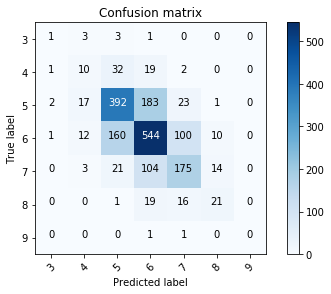

In [990]:
cm = confusion_matrix(y_true = y_test, 
                 y_pred = y_pred)

plot_confusion_matrix(cm, range(min(y_test),max(y_test)+1))
plt.show()

__Decision Tree__

In [995]:
dt = DecisionTreeClassifier()

dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
print(mean_absolute_error(y_true=y_test, y_pred=y_pred))

0.49498151082937136


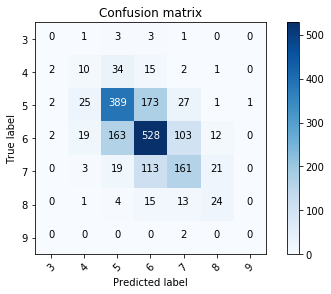

In [996]:
cm = confusion_matrix(y_true = y_test, 
                 y_pred = y_pred)

plot_confusion_matrix(cm, range(min(y_test),max(y_test)+1))
plt.show()

__Random Forest__

In [997]:
rf = RandomForestClassifier()

rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print(mean_absolute_error(y_true=y_test, y_pred=y_pred))

0.4051769677760169


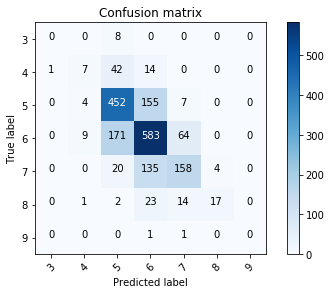

In [998]:
cm = confusion_matrix(y_true = y_test, 
                 y_pred = y_pred)

plot_confusion_matrix(cm, range(min(y_test),max(y_test)+1))
plt.show()

Out of these three models, the one with the best MAD score is the Random Forest Classifier, with a 0.4 MAD. Now, I will tune it using the GridSearchCV to optimize for n_estimators, class_weight. The evaluation will be sone with a 10-Fold cross validation.

In [1042]:
param_grid={'n_estimators':np.arange(1,100,5),
            'class_weight':['balanced', None]}

gsearch = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error')
gsearch.fit(x, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96]), 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [1043]:
gsearch.best_params_

{'class_weight': 'balanced', 'n_estimators': 61}

Training the best Random Forest:

In [1046]:
rf = RandomForestClassifier(class_weight='balanced', n_estimators = 61)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print(mean_absolute_error(y_true=y_test, y_pred=y_pred))

0.3718964606444797


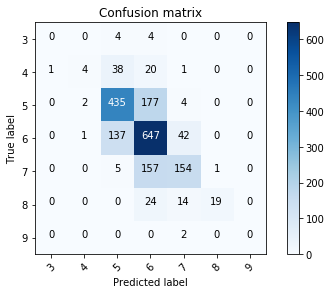

In [1047]:
cm = confusion_matrix(y_true = y_test, 
                 y_pred = y_pred)

plot_confusion_matrix(cm, range(min(y_test),max(y_test)+1))
plt.show()

This tuned model has a MAD of 0.37, which is lower than the original 0.4 for the default Random Forest. The confusion matrix also shows that the model is seldomly wrong by more than 1 score, which is not bad.